<a href="https://colab.research.google.com/github/ChaitaliV/IITDelhi-RA/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install nltk
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=918920b0b35b73e01bb58db662eed27697b2fe3291cbecfd2661b

In [2]:
import torch
import requests
import json
import pandas as pd
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import evaluate
from datasets import load_metric
import numpy as np
import nltk

Get Data

In [3]:
!git clone https://github.com/ChaitaliV/IITDelhi-RA

Cloning into 'IITDelhi-RA'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (17/17), 37.79 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
data = pd.read_csv('IITDelhi-RA/dataset.csv')
data = data.sample(frac=1.0, random_state=42)

## Initialization

In [24]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
device = 'cuda:0'
pattern_len = 218
response_len = 512
batch_size = 4
epochs = 10
optimizer = AdamW(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_d

## Prepare Data
* load the dataset
* since it is seq2seq model pre-training, I used T5 tokenizer and created, input_ids and attention masks for encoder, and used labels for decoder(labels are basically input_ids of tokenized target text, I didn't use attention_mask of decoder due to GPU running out of memory during training, but labels are capable of getting decoder attention_masks for T5 model while training so it's okay.)
* Then I created train-test split on the data, with 0.1 data used for validation, since the dataset is small, I am not taking out "test" data, coz focus is on training method, rather than checking final accuracy on test data.
* created dataloaders for both training data and validation data

In [6]:
class Prepare_Data():
  """
  this class will take the dataframe and,
  -- tokenize the text, get input_ids, attention_masks, and labels
  -- make train-validation split
  -- create dataloaders for training and validation data
  """
  def __init__(self, tokenizer, dframe, q_len, t_len):
    self.tokenizer = tokenizer
    self.p_len = pattern_len
    self.r_len = response_len
    self.data = dframe
    self.sentences = self.data.pattern.values
    self.responses = self.data.response.values
    self.tags = self.data.tag.values

  def prepare_dataloader(self):
    # tokenize pattern + tag (as input features- encoder)
    pattern_tokenized = self.tokenizer([str(sequence) for sequence in self.sentences],[str(tag) for tag in self.tags], max_length=self.p_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt")

    # tokenize target response(as target - decoder)
    response_tokenized = self.tokenizer([str(response) for response in self.responses], max_length=self.r_len, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True, return_tensors = "pt")


    ## get labels, input_ids, and attention_mask
    labels = response_tokenized.input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    input_ids = pattern_tokenized.input_ids
    attention_mask = pattern_tokenized.attention_mask

    #create train, validation split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 2018, test_size = 0.1 )
    train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids,
                                             random_state=2018, test_size=0.1)

    #create dataloaders for training and validation data
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [7]:
LoadData = Prepare_Data(tokenizer, data, pattern_len, response_len)
train_dataloader, validation_dataloader = LoadData.prepare_dataloader()

## Train the Model
* used Adam optmizer for this task
* trained the model on training dataset, and then evaluated it in validation dataset

In [25]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [26]:
# The Training Loop
t = []
# Store our loss and accuracy for plotting
train_loss_set = []
val_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  #set model in training mode
  model.train()

  #tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    #forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    #backward pass
    loss.backward()
    #update parameters and take a step using the computed gradient
    optimizer.step()

    #update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
    train_loss = tr_loss/nb_tr_steps
    train_loss_set.append(train_loss)

  print("Train loss: {}".format(train_loss))


  # Evaluation

  #put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  #tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #evaluate data for one epoch
  for batch in validation_dataloader:
    #add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    e_loss = outputs['loss']

    #calculate loss for the whole batch
    eval_loss += e_loss.item()
    nb_eval_steps += 1
    val_loss = eval_loss/nb_eval_steps
    val_loss_set.append(val_loss)

  print("Validation loss: {}".format(val_loss))


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: ignored

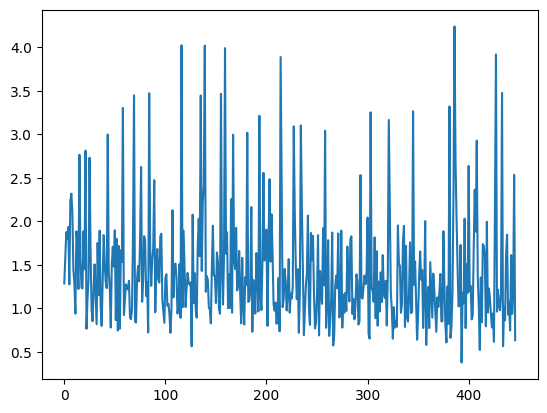

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,447), train_loss_set)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
torch.save(model,r'/content/drive/MyDrive/T5.pt')
